In [1]:
import os, sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import json
import pydicom
import skimage.io
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob 
from skimage.transform import resize

import keras

Using TensorFlow backend.


In [2]:

DATA_DIR = '../pneumonia/'
ROOT_DIR = './'


In [3]:
import random

train_dicom_dir = os.path.join(DATA_DIR, 'stage_2_train_images')
test_dicom_dir = os.path.join(DATA_DIR, 'stage_2_test_images')

def parse_dataset(anns): 
    image_annotations = []
    for index, row in anns.iterrows():
        row['path'] = os.path.join(train_dicom_dir, row['patientId']+'.dcm')
        image_annotations.append(row)
    return image_annotations 

# training dataset
anns = pd.read_csv(os.path.join(DATA_DIR, 'stage_2_train_labels.csv'))
image_annotations = parse_dataset(anns=anns)

random.shuffle(image_annotations)

print(anns[anns['Target'] == 0])
print(anns[anns['Target'] == 1])

s = len(image_annotations)
train_image_annotations = image_annotations[:round(s * 0.7)]
validation_image_annotations = image_annotations[round(s * 0.7):(round(s * 0.7)+round(s * 0.15))]
test_image_annotations = image_annotations[(round(s * 0.7)+round(s * 0.15)):]

print(len(train_image_annotations))

                                  patientId   x   y  width  height  Target
0      0004cfab-14fd-4e49-80ba-63a80b6bddd6 NaN NaN    NaN     NaN       0
1      00313ee0-9eaa-42f4-b0ab-c148ed3241cd NaN NaN    NaN     NaN       0
2      00322d4d-1c29-4943-afc9-b6754be640eb NaN NaN    NaN     NaN       0
3      003d8fa0-6bf1-40ed-b54c-ac657f8495c5 NaN NaN    NaN     NaN       0
6      00569f44-917d-4c86-a842-81832af98c30 NaN NaN    NaN     NaN       0
...                                     ...  ..  ..    ...     ...     ...
30216  c1cf3255-d734-4980-bfe0-967902ad7ed9 NaN NaN    NaN     NaN       0
30217  c1e228e4-b7b4-432b-a735-36c48fdb806f NaN NaN    NaN     NaN       0
30218  c1e3eb82-c55a-471f-a57f-fe1a823469da NaN NaN    NaN     NaN       0
30223  c1edf42b-5958-47ff-a1e7-4f23d99583ba NaN NaN    NaN     NaN       0
30224  c1f6b555-2eb1-4231-98f6-50a963976431 NaN NaN    NaN     NaN       0

[20672 rows x 6 columns]
                                  patientId      x      y  width  height  

In [4]:
class train_data_generator:
    
    def create(dataset_info, batch_size, shape, border=128):
        while True:
                        
            batch_info = [dataset_info[i] for i in np.random.choice(len(dataset_info), batch_size)]
            batch_crop_image = np.empty((batch_size, shape[0], shape[1], shape[2]))
            batch_labels = np.zeros((batch_size,1))
            for i, e in enumerate(batch_info):
                
                #get fullsize image
                fp = e['path']
                full_image = None
                if fp.split('.')[-1] == 'dcm':
                    ds = pydicom.read_file(fp)
                    full_image = ds.pixel_array
                if fp.split('.')[-1] == 'jpeg' or fp.split('.')[-1] == 'png':
                    full_image = skimage.io.imread(fp)
                
                # crop image
                if not e['Target']:
                    x = np.random.randint(border, full_image.shape[0]-shape[0]-border)
                    y = np.random.randint(border, full_image.shape[1]-shape[1]-border)
                else:
                    x = int(e['x'] + (e['width']/2) - (shape[0]/2))
                    y = int(e['y'] + (e['height']/2) - (shape[1]/2))
                    batch_labels[i] = 1
                    
                crop_image = full_image[y:y+shape[0], x:x+shape[1]].copy()
                
                if np.random.uniform(0,1) > 0.5:
                    crop_image = np.fliplr(crop_image)
                
                if crop_image.shape[:2] != (shape[0], shape[1]):
                    break
                
                # If grayscale. Convert to RGB for consistency.
                if len(crop_image.shape) == 3:
                    if crop_image.shape[2] > 3:
                        crop_image = crop_image[:,:,0]
                if len(crop_image.shape) != 3 or crop_image.shape[2] != 3:
                    crop_image = np.stack((crop_image,) * 3, -1)
                batch_crop_image[i] = crop_image
            yield batch_crop_image/255, batch_labels

In [5]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.callbacks import ModelCheckpoint
from keras import metrics
from keras.optimizers import Adam 
from keras import backend as K
import keras

def create_model(input_shape, n_out):
    pretrain_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    model = Sequential()
    model.add(pretrain_model)
    model.add(Flatten())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1024))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(n_out))
    model.add(Activation('sigmoid'))
    return model

In [6]:
keras.backend.clear_session()

if os.path.exists('./keras_len.model'):
    model = load_model('./keras_len.model')
elif os.path.exists('./inceptionresnetv2-classificator/keras.model'):
    model = load_model('./inceptionresnetv2-classificator/keras.model')
else:
    model = create_model(
        input_shape=(299,299,3),
        n_out=1)

model.layers[0].trainable = False

model.compile(
    loss='binary_crossentropy', 
    optimizer=Adam(0.000001), 
    metrics=['acc'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 8, 8, 1536)        54336736  
_________________________________________________________________
flatten_1 (Flatten)          (None, 98304)             0         
_________________________________________________________________
activation_204 (Activation)  (None, 98304)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 98304)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              100664320 
_________________________________________________________________
activation_205 (Activation)  (None, 1024)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)             

In [7]:
epochs = 50; batch_size = 16
checkpointer = ModelCheckpoint(
    './keras_len.model', 
    verbose=2, 
    save_best_only=True)

train_generator = train_data_generator.create(
    train_image_annotations, batch_size, (299,299,3))
validation_generator = train_data_generator.create(
    validation_image_annotations, 100, (299,299,3))

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    validation_data=next(validation_generator),
    epochs=epochs, 
    verbose=1,
    callbacks=[checkpointer])

Epoch 1/50
100/100 [==============================] - 47s 466ms/step - loss: 0.7376 - acc: 0.6294 - val_loss: 0.6234 - val_acc: 0.7000

Epoch 00001: val_loss improved from inf to 0.62344, saving model to ./keras_len.model
Epoch 2/50
100/100 [==============================] - 28s 279ms/step - loss: 0.6726 - acc: 0.6687 - val_loss: 0.6332 - val_acc: 0.7100

Epoch 00002: val_loss did not improve from 0.62344
Epoch 3/50
100/100 [==============================] - 28s 284ms/step - loss: 0.6268 - acc: 0.6925 - val_loss: 0.6629 - val_acc: 0.7100

Epoch 00003: val_loss did not improve from 0.62344
Epoch 4/50
100/100 [==============================] - 28s 279ms/step - loss: 0.6231 - acc: 0.6900 - val_loss: 0.7122 - val_acc: 0.7000

Epoch 00004: val_loss did not improve from 0.62344
Epoch 5/50
100/100 [==============================] - 28s 280ms/step - loss: 0.5578 - acc: 0.7287 - val_loss: 0.6738 - val_acc: 0.7100

Epoch 00005: val_loss did not improve from 0.62344
Epoch 6/50
100/100 [==========

100/100 [==============================] - 28s 280ms/step - loss: 0.3459 - acc: 0.8525 - val_loss: 0.7579 - val_acc: 0.7100

Epoch 00044: val_loss did not improve from 0.59484
Epoch 45/50
100/100 [==============================] - 28s 280ms/step - loss: 0.3534 - acc: 0.8381 - val_loss: 0.7915 - val_acc: 0.7100

Epoch 00045: val_loss did not improve from 0.59484
Epoch 46/50
100/100 [==============================] - 28s 280ms/step - loss: 0.3602 - acc: 0.8444 - val_loss: 0.6807 - val_acc: 0.7200

Epoch 00046: val_loss did not improve from 0.59484
Epoch 47/50
100/100 [==============================] - 28s 280ms/step - loss: 0.3442 - acc: 0.8425 - val_loss: 0.7488 - val_acc: 0.7100

Epoch 00047: val_loss did not improve from 0.59484
Epoch 48/50
100/100 [==============================] - 28s 280ms/step - loss: 0.3516 - acc: 0.8369 - val_loss: 0.7027 - val_acc: 0.7200

Epoch 00048: val_loss did not improve from 0.59484
Epoch 49/50
100/100 [==============================] - 28s 280ms/step - 

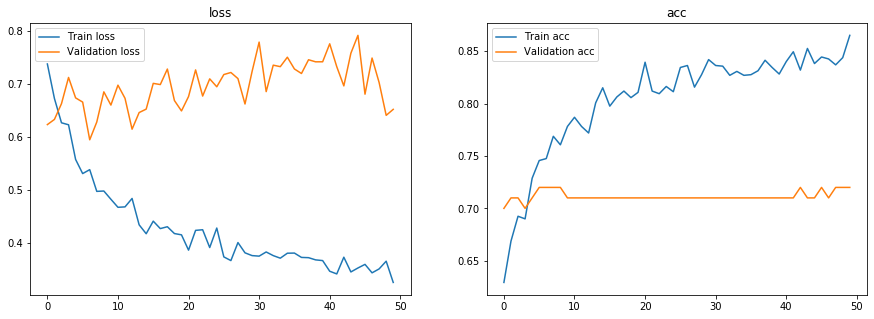

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].set_title('loss')
ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax[1].set_title('acc')
ax[1].plot(history.epoch, history.history["acc"], label="Train acc")
ax[1].plot(history.epoch, history.history["val_acc"], label="Validation acc")
ax[0].legend()
ax[1].legend()

In [9]:
if os.path.exists('./keras.model'):
    model = load_model('./keras.model')
elif os.path.exists('./inceptionresnetv2-classificator/keras.model'):
    model = load_model('./inceptionresnetv2-classificator/keras.model')
    !cp "./inceptionresnetv2-classificator/keras.model" "./"

In [10]:
validation_generator = train_data_generator.create(
    validation_image_annotations, 100, (299,299,3))

In [11]:
true_labels = []; predict_labels = []; 
for i in range(50):
    imgs, labels = next(validation_generator)
    true_labels += [int(label) for label in labels]
    predict_labels += [float(predict) for predict in model.predict(imgs)]

In [12]:
true_labels = np.array(true_labels)
predict_labels = (np.array(predict_labels) > 0.5).astype(int)

In [13]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(
    confusion_matrix(true_labels, predict_labels),
    columns=[['predict', 'predict'],['N', 'P']],
    index=[['true', 'true'],['N', 'P']])

predict     
             N    P
true N    3522   40
     P    1260  178

In [14]:
from sklearn.metrics import f1_score
f1_score(true_labels, predict_labels, average='macro')

0.5295876350734828